In [35]:
import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import utils as ut
from tqdm import tqdm
from astropy.nddata import block_reduce
import astropy.convolution as ac
import scipy.ndimage as ndimage
from scipy.ndimage import zoom

In [24]:
# Modeling PSF

pixel_size = 57

D = 1.0 # m 
llambda = 630E-9 # m 

diff_limit = 1.22 * llambda / D * 206265

diff_limit_km = diff_limit * 720

diff_limit_px = diff_limit_km / pixel_size

print("Diffraction limit in pixels is: ", diff_limit_px)

psf = ac.AiryDisk2DKernel(diff_limit_px)

PSF = fits.PrimaryHDU(psf)
PSF.writeto("psf.fits", overwrite=True)

Diffraction limit in pixels is:  2.0025508926315787


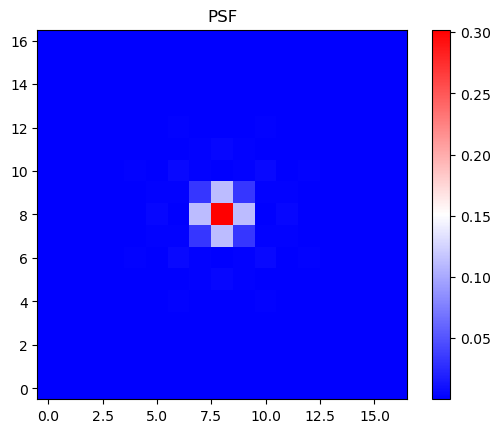

In [26]:
# Plotting PSF

plt.imshow(psf, origin= 'lower', cmap = 'bwr')
plt.title(r'PSF')
plt.colorbar()
plt.show()

In [46]:
# Binning

# Importing data
stokes_original = fits.open('qs_ph_disk_center_synth.fits')[0].data[:256, :256, :,:]

# Binning factor
bin_factor = 57 / 16

# Target shape for the spatial dimensions
target_shape_x = int(stokes_original.shape[0] / bin_factor)
target_shape_y = int(stokes_original.shape[1] / bin_factor)

# Initializing of new shape
new_shape = (target_shape_x, target_shape_y, stokes_original.shape[2], stokes_original.shape[3])
binned_data = np.zeros(new_shape)

# Calculation of precise zoom factors to match the target shape
zoom_factors = (target_shape_x / stokes_original.shape[0], target_shape_y / stokes_original.shape[1])

# Applying zoom for each Stokes parameter and wavelength
for i in tqdm(range(stokes_original.shape[3])):
    for j in range(stokes_original.shape[2]):
        # Zoom the data
        binned_data[:, :, j, i] = zoom(stokes_original[:, :, j, i], zoom_factors, order=0)  # order=0 for nearest neighbor

# ut.writeFits('binned.fits', binned_data)
print(binned_data.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:05<00:00, 37.64it/s]

(71, 71, 4, 201)


In [47]:
# Convolution

convolved_data = np.zeros((binned_data.shape))
for i in tqdm(range(binned_data.shape[3])): 
    for j in range(binned_data.shape[2]): 
        result = ac.convolve(binned_data[:, :, j, i], psf, boundary='wrap')
        convolved_data[:, :, j, i] = result
ut.writeFits('convolved_data.fits', convolved_data)
print(convolved_data.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:02<00:00, 75.85it/s]

[info] writeFits: writing -> convolved_data.fits
(71, 71, 4, 201)


(71, 71, 4, 201)


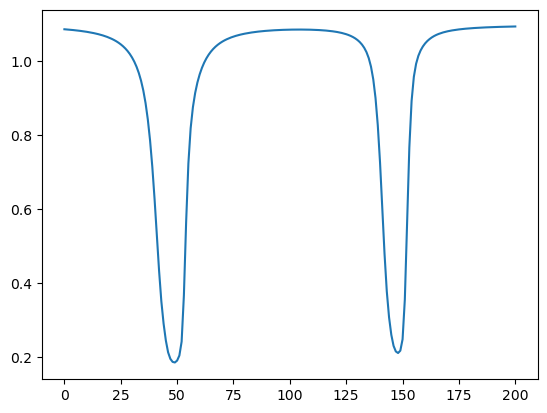

In [49]:
# Normalize convolved data
mean_continuum = np.mean(convolved_data[:,:,0,-10:])
convolved_data /= mean_continuum

print(convolved_data.shape)
plt.plot(convolved_data[0, 0, 0, :])
plt.show()

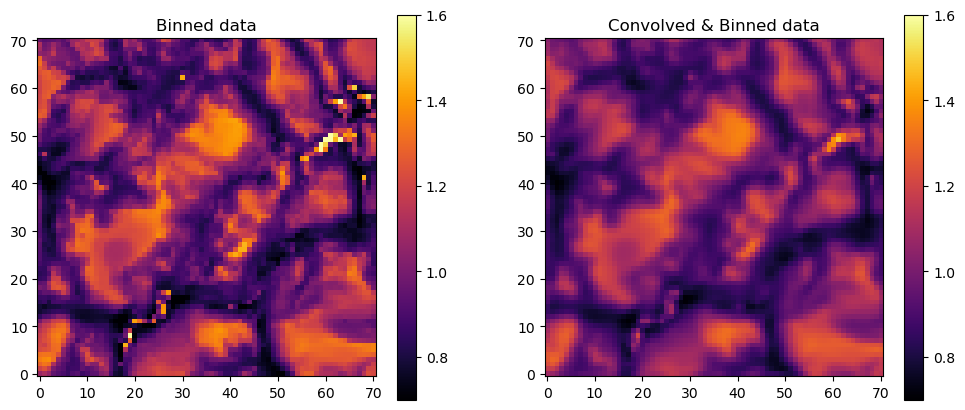

In [50]:
# Comparing the binned and convolved data

plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.imshow(binned_data[:,:,0,0], origin='lower', cmap='inferno', vmin=0.7, vmax=1.6)
plt.title(r'Binned data')
plt.colorbar()

plt.subplot(122)
plt.imshow(convolved_data[:,:,0,0], origin='lower', cmap='inferno', vmin=0.7, vmax=1.6)
plt.title(r'Convolved & Binned data')
plt.colorbar()
plt.show()

In [51]:
# Correlation coefficient

correlation = np.corrcoef(binned_data.flatten(), convolved_data.flatten())[0, 1]
print('Correlation coefficient:', correlation.round(4))

Correlation coefficient: 0.9982


In [42]:
# INVERSION

import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import utils as ut

# Importing data

def waveGrid(nw):
    
    wav = np.arange(nw) * 0.01 + 6301.0
    return wav
    
def loadData(clip_threshold = 0.99):

    data = ut.readFits('convolved_data.fits')
    mean_continuum = np.mean(data[:,:,0,-10:])
    data /= mean_continuum

    obs = data[:32,:32, :, :] 
    wav = waveGrid(obs.shape[-1])
 
    sig = np.zeros([4,len(wav)])
    sig[:,:] = 1e-3
    sig[1:4,:] /= 10.0

    psf = ut.readFits('psf.fits')
    
    return [[wav, None]], [[obs, sig, psf/psf.sum(), clip_threshold]]

if __name__ == "__main__":

    nthreads = 12 # adapt this number to the number of cores that are available in your machine
    
    # Load data
    region, sregion = loadData()

    # Init ME inverter
    me = ME.MilneEddington(region, [6301, 6302], nthreads=nthreads)
    
    # generate initial model
    nx, ny = sregion[0][0].shape[0:2]
    Ipar = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
    m = me.repeat_model(Ipar, nx, ny)
    
    # Invert pixel by pixel
    mpix, syn, chi2 = me.invert(m, sregion[0][0], sregion[0][1], nRandom=20, nIter=50, chi2_thres=1.0, mu=0.96)
    ut.writeFits("modelout_ptp", mpix)
    # smooth model
    m = ut.smoothModel(mpix, 4)


    # invert spatially-coupled with initial guess from pixel-to-pixel (less iterations)
    m1, chi = me.invert_spatially_coupled(m, sregion, mu=0.96, nIter=1, alpha=100., \
                                    alphas = np.float64([1,1,1,0.01,0.01,0.01,0.01,0.01,0.01]),\
                                    init_lambda=10.0)

    

    # smooth model with very narrow PSF and restart with less regularization (lower alpha)
    m = ut.smoothModel(m1, 2)

    
    # invert spatially-coupled 
    m1, chi = me.invert_spatially_coupled(m, sregion, mu=0.96, nIter=2, alpha=10., \
                                      alphas = np.float64([2,2,2,0.01,0.01,0.01,0.01,0.01,0.01]),\
                                      init_lambda=1.0)
    
    ut.writeFits("modelout_sc.fits", m1)

[info] readFits: reading -> convolved_data.fits
[info] readFits: reading -> psf.fits
pyMilne::dealloc: cleaning-up...


line::line: Initialized [6301.499500] ->  12 Zeeman components
line::line: Initialized [6302.493100] ->   3 Zeeman components
InvertMany: Processed -> 100%
[info] SparseRegion: Initializing degradation operator and cross-correlation matrix ... done


[info] writeFits: writing -> modelout_ptp


[info] invert: preallocating Hessian matrix ... populating ... done

[info] invert: sparse Hessian size -> 0.252439 GBytes

[info] invert: iter=  0, Chi2=  12770.62320 (2.192743e+00)
       [Constructing coupled linear system -> dt=10.534000 s]
       [Solving coupled linear system, Lambda=1.000000e+01: initial solution, solving system -> dt=0.893000 s]

[info] invert: iter=  1, Chi2=  11124.56720 (Reg=2.177954e+00), Lambda=1.000000e+01
[info] invert: inversion finalized, Chi2=1.112457e+04


[info] writeFits: writing -> modelout_sc.fits


[info] SparseRegion: Initializing degradation operator and cross-correlation matrix ... done
[info] invert: preallocating Hessian matrix ... populating ... done

[info] invert: sparse Hessian size -> 0.252439 GBytes

[info] invert: iter=  0, Chi2=  11062.80403 (3.199708e-01)
       [Constructing coupled linear system -> dt=10.479000 s]
       [Solving coupled linear system, Lambda=1.000000e+00: initial solution, solving system -> dt=1.734000 s]

[info] invert: iter=  1, Chi2=   5874.34226 (Reg=7.984417e-01), Lambda=1.000000e+00
       [Constructing coupled linear system -> dt=10.144000 s]
       [Solving coupled linear system, Lambda=3.636364e-01: initial solution, solving system -> dt=1.762000 s]

[info] invert: iter=  2, Chi2=   4256.49368 (Reg=1.201757e+00), Lambda=3.636364e-01
[info] invert: inversion finalized, Chi2=4.256494e+03


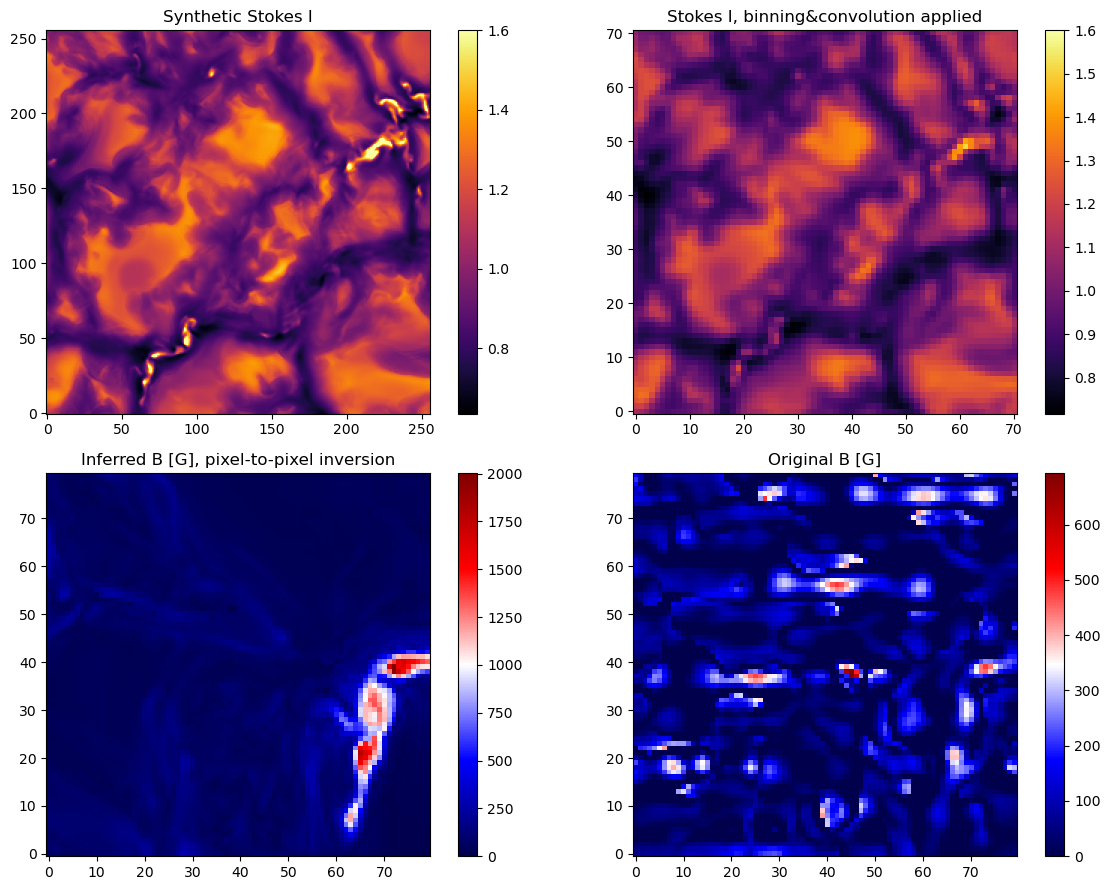

In [44]:
# Plotting

plt.figure(figsize=[12, 9])

stokes = fits.open('qs_ph_disk_center_synth.fits')[0].data[:256, :256, :, :]
convolved = fits.open('convolved_data.fits')[0].data
atmos = fits.open('qs_ph_disk_center.fits')[0].data[:, :, :256, :256]

modelout_ptp = fits.open('modelout_ptp.fits')[0].data
modelout_sc = fits.open('modelout_sc.fits')[0].data

plt.subplot(2, 2, 1)
plt.imshow(stokes[:,:,0,0], origin='lower', cmap='inferno',vmin=0.6, vmax=1.6)
plt.title(r'Synthetic Stokes I')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(convolved[:,:,0,0], origin='lower', cmap='inferno',vvmax=1.6)
plt.title(r'Stokes I, binning&convolution applied')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(modelout_ptp[:,:,0], origin='lower', cmap='seismic')
plt.title(r'Inferred B [G], pixel-to-pixel inversion')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(modelout_sc[:,:,0], origin='lower', cmap = 'seismic')
plt.title(r'Original B [G]')
plt.colorbar()
plt.tight_layout()

plt.show()